In [1]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(2)

from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GRU

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [2]:
df = pd.read_csv('output.csv')
df.head()

time  Toffice_reference  humidity  detected_motions  \
0  2015-01-06 15:00:00              19.45      42.0                 0   
1  2015-01-06 15:05:00              19.45      42.0                 0   
2  2015-01-06 15:10:00              19.45      42.0                 0   
3  2015-01-06 15:15:00              19.45      42.0                 1   
4  2015-01-06 15:20:00              19.45      42.0                 0   

   occupancy  office_CO2_concentratio     door     label  
0        0.0               469.265967  1.00000  1.128000  
1        0.0               448.187067  1.00000  0.622000  
2        0.0               454.433067  1.00000  0.634000  
3        0.0               457.387200  0.39944  0.285733  
4        0.0               444.462833  0.00000  0.094000

In [3]:
df.tail()

time  Toffice_reference  humidity  detected_motions  \
102925  2015-12-30 00:05:00              18.35      33.0                 0   
102926  2015-12-30 00:10:00              18.35      33.0                 0   
102927  2015-12-30 00:15:00              18.35      33.0                 0   
102928  2015-12-30 00:20:00              18.35      33.0                 0   
102929  2015-12-30 00:25:00              18.35      33.0                 0   

        occupancy  office_CO2_concentratio  door  label  
102925        0.0                    430.0   0.0   0.01  
102926        0.0                    430.0   0.0   0.01  
102927        0.0                    430.0   0.0   0.01  
102928        0.0                    430.0   0.0   0.01  
102929        0.0                    430.0   0.0   0.01

In [4]:
#Find missing data!
pd.date_range('2015-01-06 15:00:00', '2015-12-30 00:25:00', freq='5Min').difference(pd.to_datetime(df["time"]))

DatetimeIndex(['2015-03-29 02:00:00', '2015-03-29 02:05:00',
               '2015-03-29 02:10:00', '2015-03-29 02:15:00',
               '2015-03-29 02:20:00', '2015-03-29 02:25:00',
               '2015-03-29 02:30:00', '2015-03-29 02:35:00',
               '2015-03-29 02:40:00', '2015-03-29 02:45:00',
               '2015-03-29 02:50:00', '2015-03-29 02:55:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
df.isna().sum()

time                       0
Toffice_reference          0
humidity                   0
detected_motions           0
occupancy                  0
office_CO2_concentratio    0
door                       0
label                      0
dtype: int64

In [6]:
df["time"]= pd.to_datetime(df["time"])
df.set_index(["time"], inplace=True)
df.head()

Toffice_reference  humidity  detected_motions  occupancy  \
time                                                                            
2015-01-06 15:00:00              19.45      42.0                 0        0.0   
2015-01-06 15:05:00              19.45      42.0                 0        0.0   
2015-01-06 15:10:00              19.45      42.0                 0        0.0   
2015-01-06 15:15:00              19.45      42.0                 1        0.0   
2015-01-06 15:20:00              19.45      42.0                 0        0.0   

                     office_CO2_concentratio     door     label  
time                                                             
2015-01-06 15:00:00               469.265967  1.00000  1.128000  
2015-01-06 15:05:00               448.187067  1.00000  0.622000  
2015-01-06 15:10:00               454.433067  1.00000  0.634000  
2015-01-06 15:15:00               457.387200  0.39944  0.285733  
2015-01-06 15:20:00               444.462833  0.00000  0.094000

In [7]:
df.drop(['Toffice_reference', 'humidity', 'detected_motions', 'occupancy', 'office_CO2_concentratio','door'], axis=1, inplace=True)

In [8]:
df.head()

label
time                         
2015-01-06 15:00:00  1.128000
2015-01-06 15:05:00  0.622000
2015-01-06 15:10:00  0.634000
2015-01-06 15:15:00  0.285733
2015-01-06 15:20:00  0.094000

In [9]:
df[df['label']<0] = 0

In [10]:
df[df['label']<0]

Empty DataFrame
Columns: [label]
Index: []

In [11]:
data_per_5min = df
data_per_Hour = df.resample('H').mean()
data_per_5min.shape, data_per_Hour.shape

((102930, 1), (8578, 1))

In [12]:
data_per_Hour

label
time                         
2015-01-06 15:00:00  0.272478
2015-01-06 16:00:00  1.830740
2015-01-06 17:00:00  1.842989
2015-01-06 18:00:00  2.603144
2015-01-06 19:00:00  2.724946
...                       ...
2015-12-29 20:00:00  0.000000
2015-12-29 21:00:00  0.011667
2015-12-29 22:00:00  0.009167
2015-12-29 23:00:00  0.010000
2015-12-30 00:00:00  0.010000

[8578 rows x 1 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

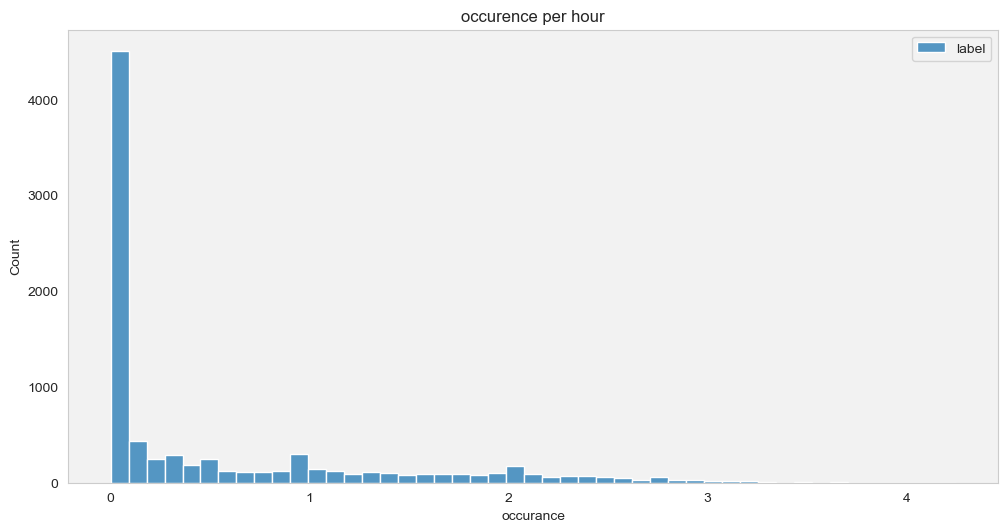

In [13]:
ax = sns.histplot(data_per_Hour)
ax.set_xlabel('occurance')
ax.set_title('occurence per hour')
ax.figure.savefig("images/data_perh.eps", bbox_inches="tight")

<AxesSubplot:ylabel='label'>

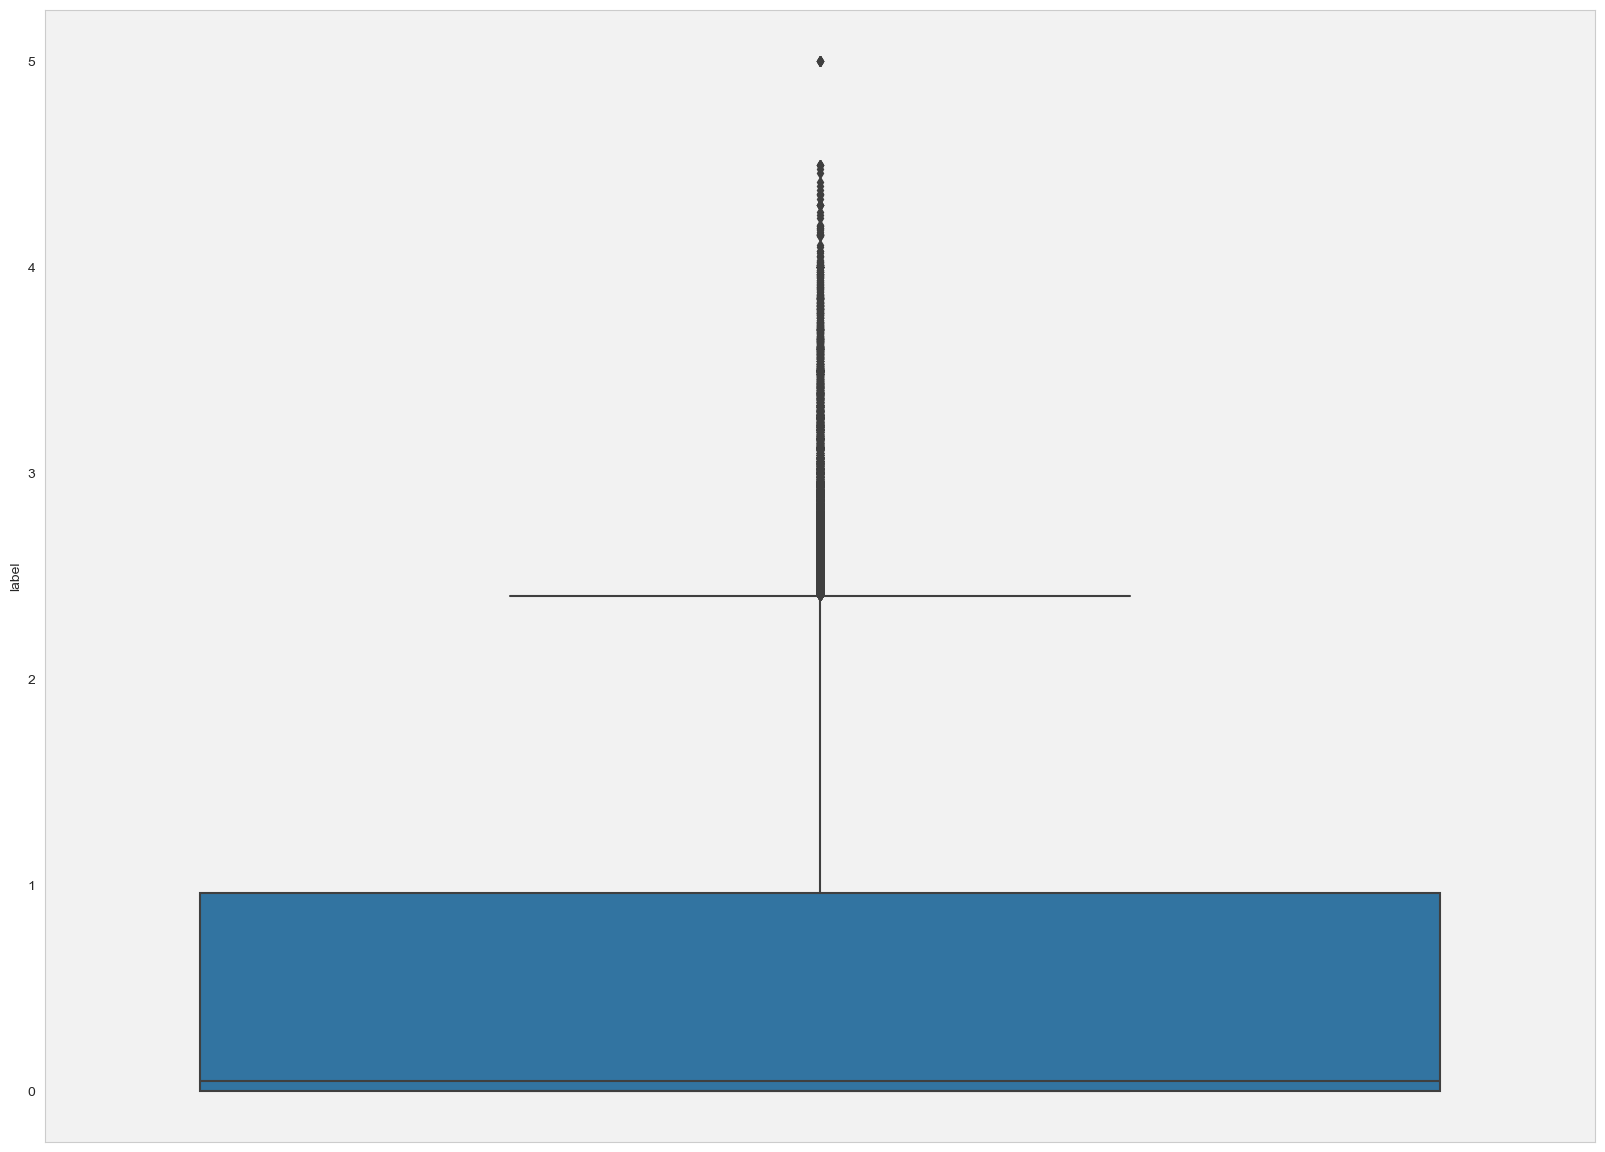

In [14]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(data=df, y='label')



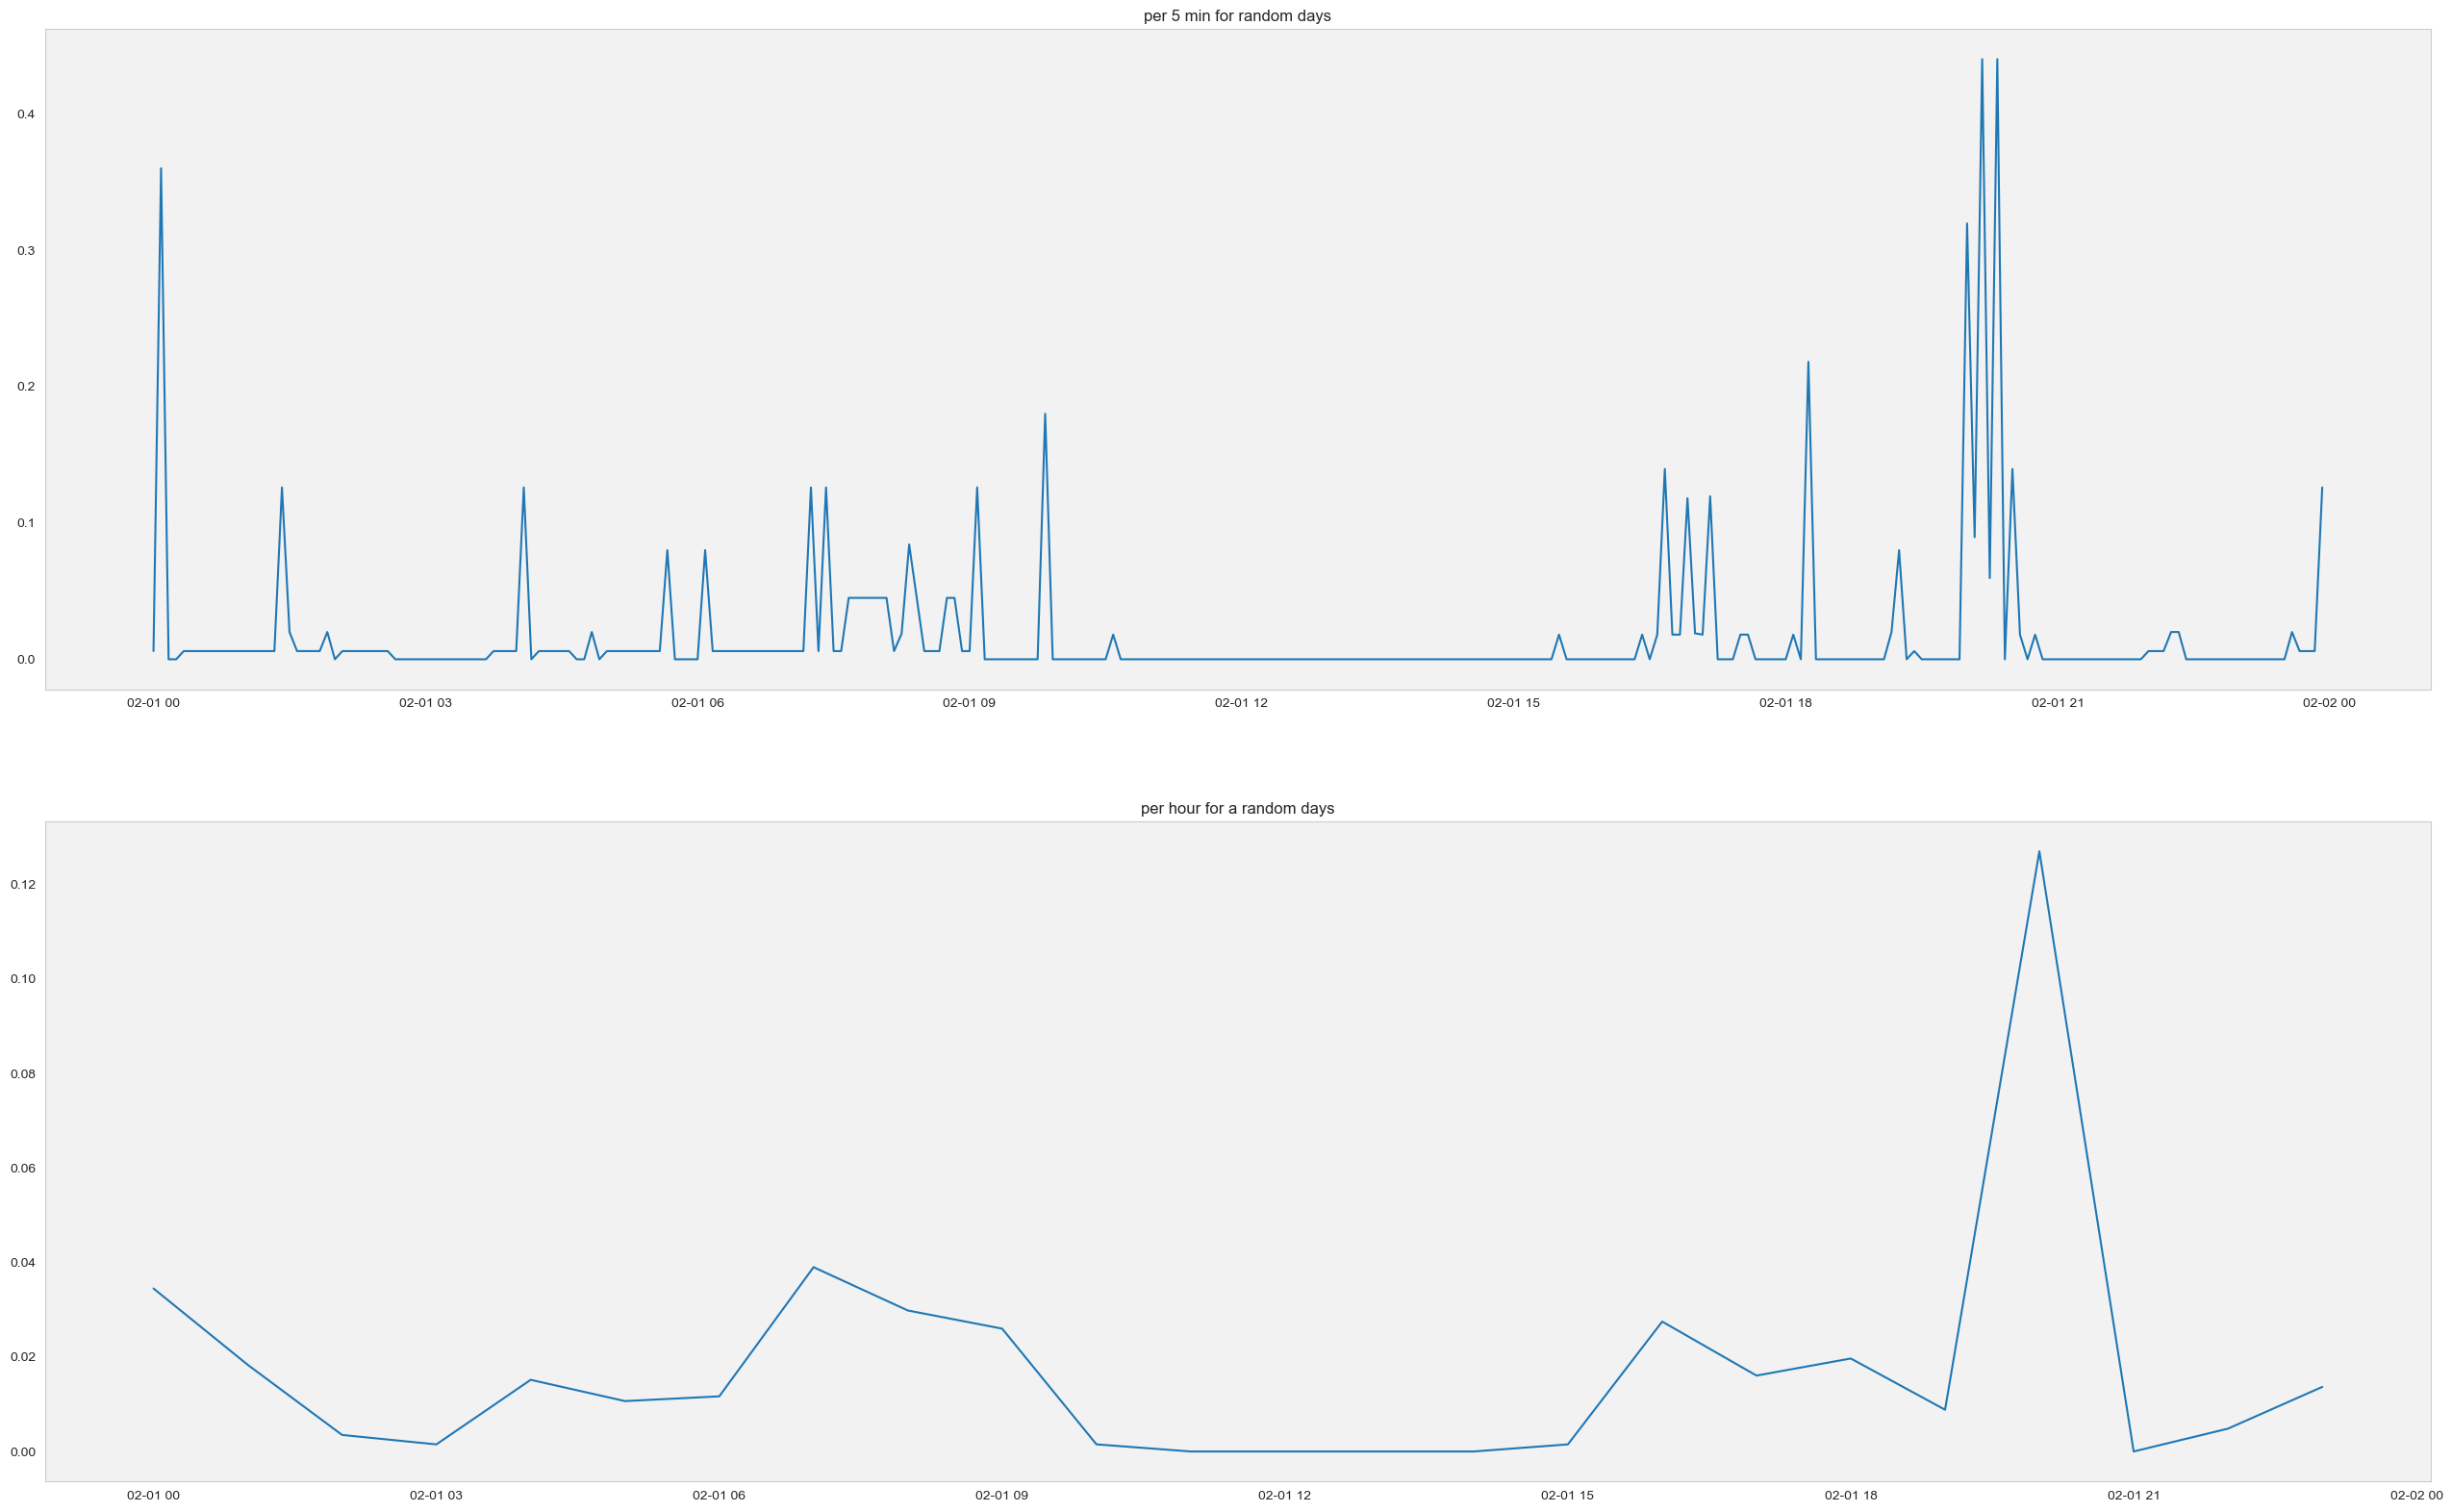

In [15]:
fig, ax = plt.subplots(figsize=(32,20))

plt.subplot(2, 1, 1)
plt.plot(data_per_5min.loc['2015-02-01']['label'])
#plt.plot(data_per_5min['occupancy'])
#plt.plot(data_per_H.loc['2019-05-01':'2019-05-07',:])
plt.title('per 5 min for random days')


plt.subplot(2, 1, 2)
plt.plot(data_per_Hour['2015-02-01']['label'])
#plt.plot(data_per_D.loc['2019-05',:])
plt.title('per hour for a random days')



plt.show()
fig.tight_layout()

In [16]:
# fig = plt.figure(figsize=(20, 15))
# ax1 = fig.add_subplot(211)
# sns.boxplot(data=data, x='month', y='label', ax=ax1)
# ax2 = fig.add_subplot(212)
# sns.boxplot(data=data, x='weekday', y='label', ax=ax2)
# # ax3 = fig.add_subplot(313)
# # sns.boxplot(data=df, x='holiday', y='label', ax=ax3)
# plt.show()

In [17]:
data = data_per_Hour[:]

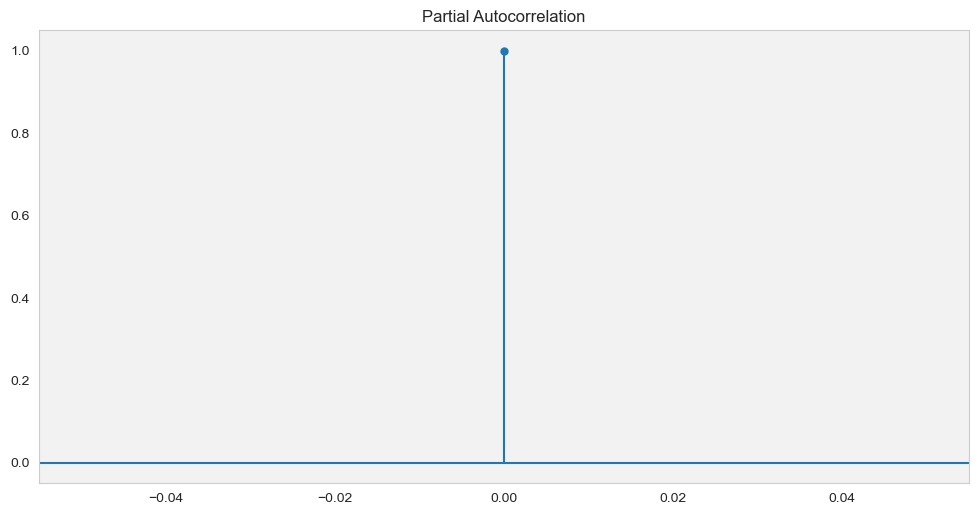

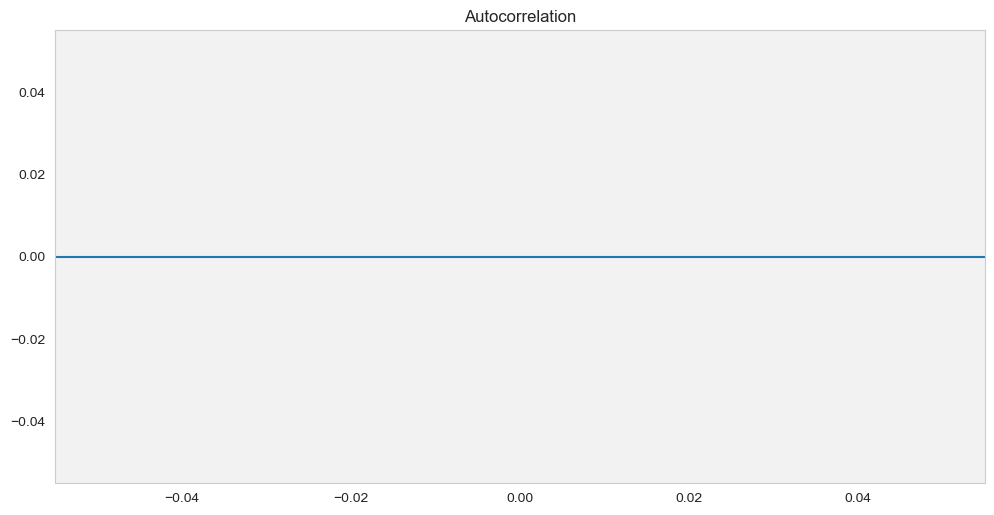

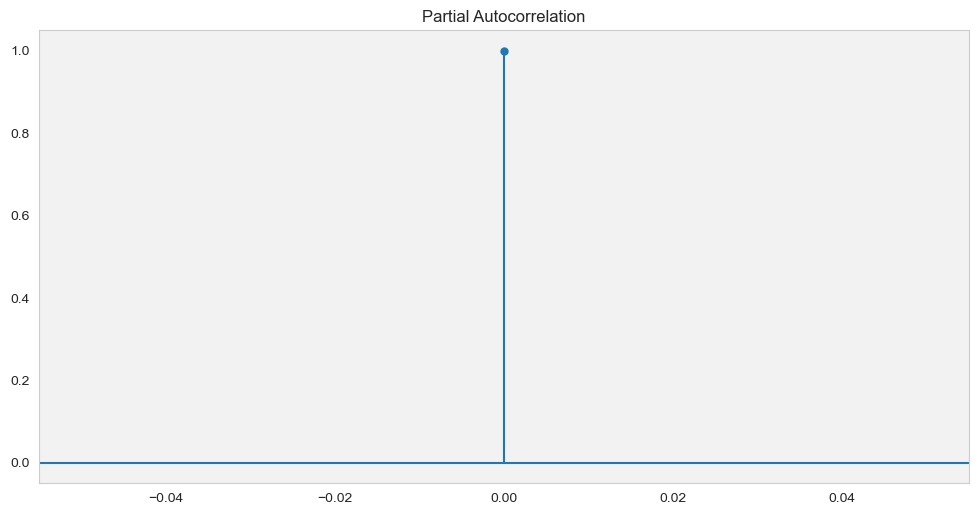

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['label'])
plot_pacf(data['label'])

# add simple cal features

In [19]:
import holidays

def add_time_features(df):
    cet_index = df.index
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    #df["year"] = cet_index.year
    return df

def add_holiday_features(df):
    de_holidays = holidays.France()
    cet_dates = pd.Series(df.index, index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df


def add_all_features(df, target_col="conso_global"):
    df = df.copy()
    df = add_time_features(df)
    #df = add_holiday_features(df)
    return df

In [20]:
data = add_all_features(data)

data.head()

label  month  weekday  hour
time                                               
2015-01-06 15:00:00  0.272478      1        1    15
2015-01-06 16:00:00  1.830740      1        1    16
2015-01-06 17:00:00  1.842989      1        1    17
2015-01-06 18:00:00  2.603144      1        1    18
2015-01-06 19:00:00  2.724946      1        1    19

In [21]:
data.describe()

label        month      weekday         hour
count  8577.000000  8578.000000  8578.000000  8578.000000
mean      0.539219     6.583003     2.997785    11.506528
std       0.798003     3.390166     2.000028     6.924434
min       0.000000     1.000000     0.000000     0.000000
25%       0.000000     4.000000     1.000000     6.000000
50%       0.066151     7.000000     3.000000    12.000000
75%       0.941503    10.000000     5.000000    18.000000
max       4.250000    12.000000     6.000000    23.000000

In [22]:
import warnings
warnings.filterwarnings('ignore')

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=np.arange(1,25),y=data.groupby(['hour'])['label'].agg({np.mean})['mean'],
                    mode='lines+markers',
                    name=f'avg occupancy'))



fig.update_layout( title_text=f"Average occupancy at hour level")
fig.show()



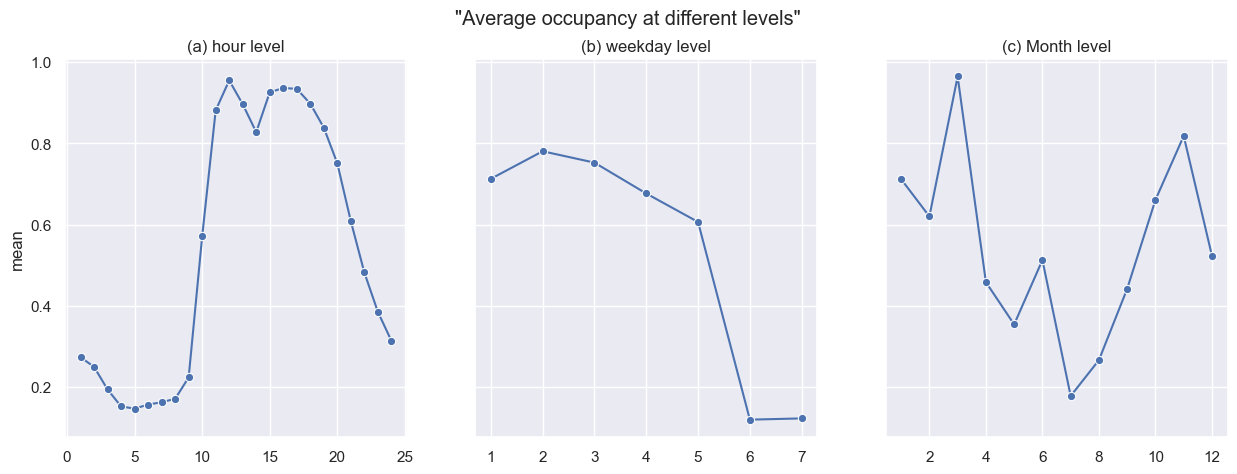

In [23]:
sns.set_theme()
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('"Average occupancy at different levels"')

# Bulbasaur
sns.lineplot(ax=axes[0], x=np.arange(1,25), y=data.groupby(['hour'])['label'].agg({np.mean})['mean'],marker="o", markers=True)
axes[0].set_title('(a) hour level')

# Charmander
sns.lineplot(ax=axes[1], x=np.arange(1,8),y=data.groupby(['weekday'])['label'].agg({np.mean})['mean'],marker="o",markers=True)
axes[1].set_title('(b) weekday level')

# Squirtle
sns.lineplot(ax=axes[2], x=np.arange(1,13),y=data.groupby(['month'])['label'].agg({np.mean})['mean'],marker="o", markers=True)
axes[2].set_title('(c) Month level')

fig.savefig("images/times.eps",bbox_inches="tight")

In [24]:
fig = make_subplots( rows=1, cols=3,
    subplot_titles=("(a)", "(b)", "(c)"))

fig.add_trace(
    go.Scatter(x=np.arange(1,25),y=data.groupby(['hour'])['label'].agg({np.mean})['mean'],
                    mode='lines+markers',
                    name=f'hour level avg occup'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(1,8),y=data.groupby(['weekday'])['label'].agg({np.mean})['mean'],
                    mode='lines+markers',
                    name=f'weekeday level avg occup'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=np.arange(1,13),y=data.groupby(['month'])['label'].agg({np.mean})['mean'],
                    mode='lines+markers',
                    name=f'month level avg occup'),
    row=1, col=3
)

fig.update_layout(height=400, width=1000, title_text="Average occupancy at different levels")
fig.show()

fig.write_image("images/times.png")

## Importing the calenda

                                         evenement               debut  \
debut                                                                    
2015-01-05 09:15:00                          POO13 2015-01-05 09:15:00   
2015-01-05 15:00:00        point Murielle sur DPEA 2015-01-05 15:00:00   
2015-01-06 13:00:00                réunion mission 2015-01-06 13:00:00   
2015-01-07 07:30:00              Rdv projet Ayesha 2015-01-07 07:30:00   
2015-01-07 08:30:00  appeler amandine pour facture 2015-01-07 08:30:00   

                                           fin  label  
debut                                                  
2015-01-05 09:15:00  2015-01-05 11:15:00+00:00      1  
2015-01-05 15:00:00  2015-01-05 16:00:00+00:00      2  
2015-01-06 13:00:00  2015-01-06 14:30:00+00:00      1  
2015-01-07 07:30:00  2015-01-07 08:30:00+00:00      1  
2015-01-07 08:30:00  2015-01-07 08:45:00+00:00      1  
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


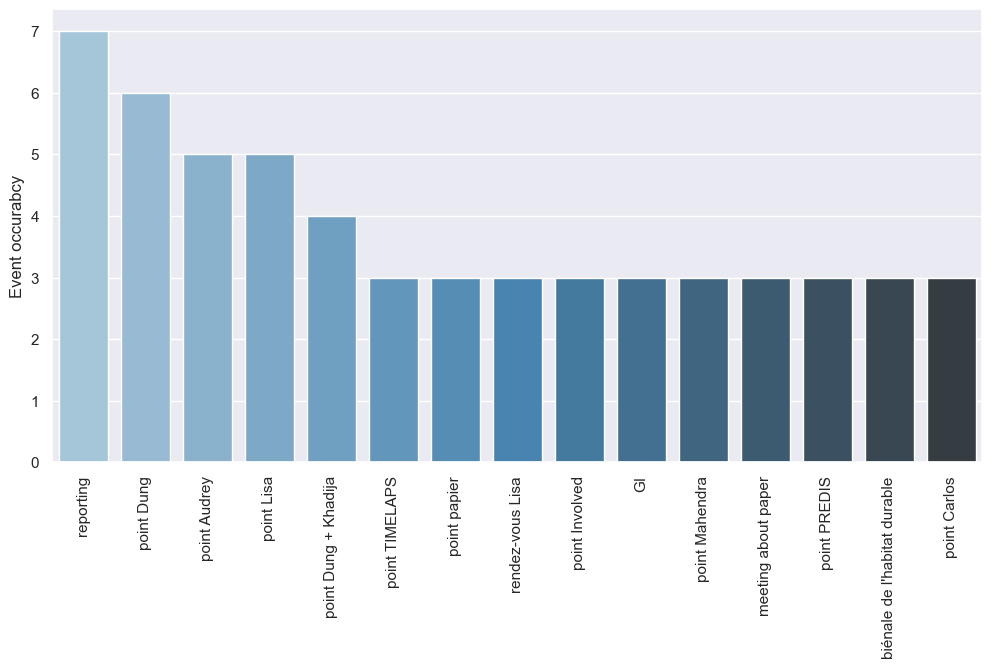

In [25]:
from icalendar import Calendar, Event
from datetime import datetime

evenement = []
debut = []
fin =[]


g = open('stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


# plt.figure(figsize=(20,9))
# calendrier.evenement.value_counts()[0:100].plot.bar()
# plt.show()


cc = calendrier.evenement.value_counts()[0:15]
events = sns.barplot(x=cc.index, y=cc.values, palette="Blues_d")
events.set( ylabel = "Event occurabcy")
for item in events.get_xticklabels():
    item.set_rotation(90)

events.figure.savefig("images/events.eps",bbox_inches="tight")

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(0)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

# plt.figure(figsize=(20,9))
# data['label'].plot()
# data['calendrier'].plot()
# plt.show()

In [26]:
data.drop(['nom'], axis =1, inplace=True)

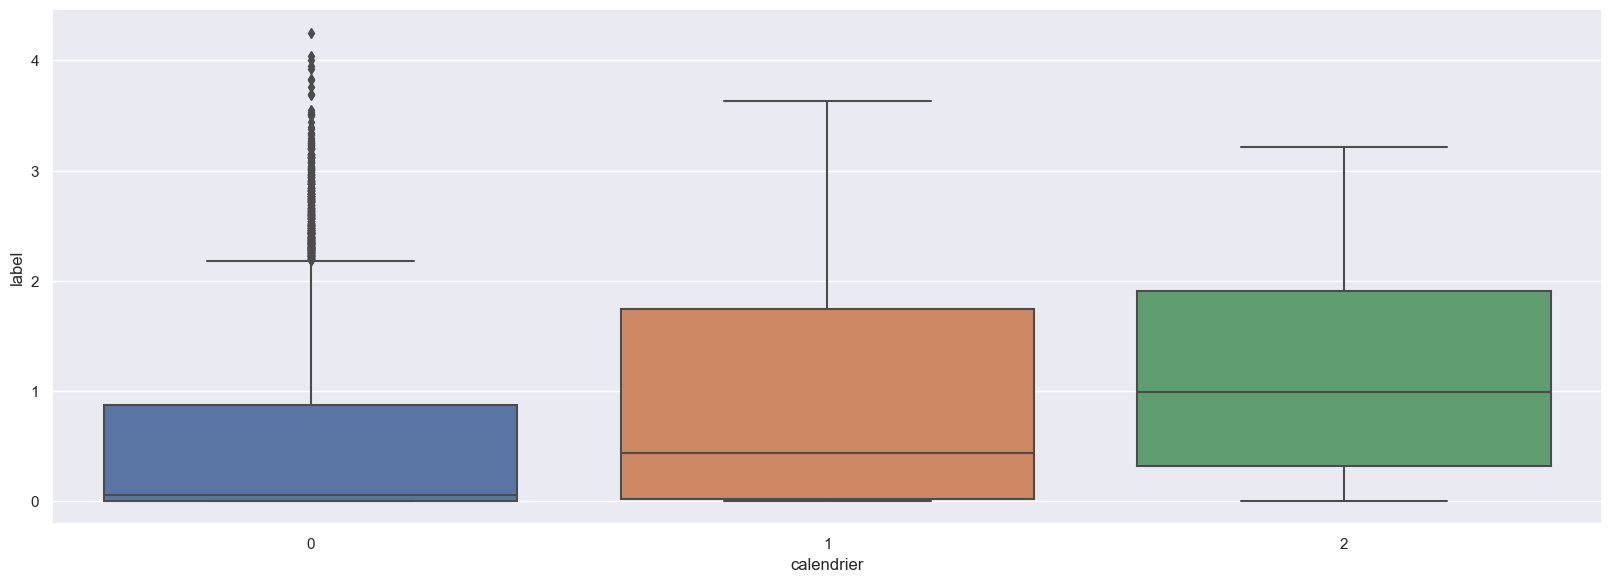

In [27]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
sns.boxplot(data=data, x='calendrier', y='label', ax=ax1)
plt.show()
fig.savefig("images/calendar.eps",bbox_inches="tight")

# window 24h: 

In [28]:
#Leads
leads = np.arange(23)
lead_cols = [f"label_lead_{lead+1}" for lead in leads ]
for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = data["label"].shift(-(lead+1))  
    
hour_leads = [f"hour_lead_{lead+1}" for lead in leads ]
weekday_leads = [f"weekday_lead_{lead+1}" for lead in leads ]
month_leads = [f"month_lead_{lead+1}" for lead in leads ]
cal_leads = [f"cal_lead_{lead+1}" for lead in leads ]


for lead, lead_H in zip(leads, hour_leads):
    data[lead_H] = data["hour"].shift(-(lead+1))
    
for lead, lead_W in zip(leads, weekday_leads):
    data[lead_W] = data["weekday"].shift(-(lead+1))
    
for lead, lead_M in zip(leads, month_leads):
    data[lead_M] = data["month"].shift(-(lead+1))
    
for lead, lead_C in zip(leads, cal_leads):
    data[lead_C] = data["calendrier"].shift(-(lead+1))      


In [29]:
#lags
lags = np.arange(1,25)
lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["label"].shift(lag)

hour_lags = [f"hour_lag_{lag}" for lag in lags ]
weekday_lags = [f"weekday_lag_{lag}" for lag in lags ]
month_lags = [f"month_lag_{lag}" for lag in lags ]
cal_lags = [f"cal_lag_{lag}" for lag in lags ]


for lag, lag_H in zip(lags, hour_lags):
    data[lag_H] = data["hour"].shift(lag)
    
for lag, lag_W in zip(lags, weekday_lags):
    data[lag_W] = data["weekday"].shift(lag)
    
for lag, lag_M in zip(lags, month_lags):
    data[lag_M] = data["month"].shift(lag)

for lag, lag_C in zip(lags, cal_lags):
    data[lag_C] = data["calendrier"].shift(lag)

In [30]:
#Rolling 

wins = [12, 24, 36, 48, 60, 72]
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).mean())
#         data[f"rmax_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).max())
#         data[f"rmin_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).min())
        data[f"rstd_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).std())

In [31]:
data.rename(columns={"label": "label_lead_0"}, inplace= True)

In [32]:
data.tail()

label_lead_0  month  weekday  hour  calendrier  \
time                                                                  
2015-12-29 20:00:00      0.000000     12        1    20           0   
2015-12-29 21:00:00      0.011667     12        1    21           0   
2015-12-29 22:00:00      0.009167     12        1    22           0   
2015-12-29 23:00:00      0.010000     12        1    23           0   
2015-12-30 00:00:00      0.010000     12        2     0           0   

                     label_lead_1  label_lead_2  label_lead_3  label_lead_4  \
time                                                                          
2015-12-29 20:00:00      0.011667      0.009167          0.01          0.01   
2015-12-29 21:00:00      0.009167      0.010000          0.01           NaN   
2015-12-29 22:00:00      0.010000      0.010000           NaN           NaN   
2015-12-29 23:00:00      0.010000           NaN           NaN           NaN   
2015-12-30 00:00:00           NaN           NaN           NaN           NaN   

                     label_lead_5  ...  rmean_20_72  rstd_20_72  rmean_21_72  \
time                               ...                                         
2015-12-29 20:00:00           NaN  ...     0.198755    0.246063     0.198755   
2015-12-29 21:00:00           NaN  ...     0.198755    0.246063     0.198755   
2015-12-29 22:00:00           NaN  ...     0.200721    0.246015     0.198755   
2015-12-29 23:00:00           NaN  ...     0.201411    0.245863     0.200721   
2015-12-30 00:00:00           NaN  ...     0.202095    0.245710     0.201411   

                     rstd_21_72  rmean_22_72  rstd_22_72  rmean_23_72  \
time                                                                    
2015-12-29 20:00:00    0.246063     0.198755    0.246063     0.198799   
2015-12-29 21:00:00    0.246063     0.198755    0.246063     0.198755   
2015-12-29 22:00:00    0.246063     0.198755    0.246063     0.198755   
2015-12-29 23:00:00    0.246015     0.198755    0.246063     0.198755   
2015-12-30 00:00:00    0.245863     0.200721    0.246015     0.198755   

                     rstd_23_72  rmean_24_72  rstd_24_72  
time                                                      
2015-12-29 20:00:00    0.246049     0.199816    0.245406  
2015-12-29 21:00:00    0.246063     0.198799    0.246049  
2015-12-29 22:00:00    0.246063     0.198755    0.246063  
2015-12-29 23:00:00    0.246063     0.198755    0.246063  
2015-12-30 00:00:00    0.246063     0.198755    0.246063  

[5 rows x 528 columns]

In [33]:
data.dropna(inplace=True)

In [34]:
data.tail()

label_lead_0  month  weekday  hour  calendrier  \
time                                                                  
2015-12-28 21:00:00      0.009365     12        0    21           0   
2015-12-28 22:00:00      0.119856     12        0    22           0   
2015-12-28 23:00:00      0.123000     12        0    23           0   
2015-12-29 00:00:00      0.123000     12        1     0           0   
2015-12-29 01:00:00      0.123000     12        1     1           0   

                     label_lead_1  label_lead_2  label_lead_3  label_lead_4  \
time                                                                          
2015-12-28 21:00:00      0.119856      0.123000      0.123000      0.123000   
2015-12-28 22:00:00      0.123000      0.123000      0.123000      0.264533   
2015-12-28 23:00:00      0.123000      0.123000      0.264533      0.172700   
2015-12-29 00:00:00      0.123000      0.264533      0.172700      0.172200   
2015-12-29 01:00:00      0.264533      0.172700      0.172200      0.172200   

                     label_lead_5  ...  rmean_20_72  rstd_20_72  rmean_21_72  \
time                               ...                                         
2015-12-28 21:00:00      0.264533  ...     0.197307    0.244829     0.197307   
2015-12-28 22:00:00      0.172700  ...     0.196642    0.244953     0.197307   
2015-12-28 23:00:00      0.172200  ...     0.198319    0.244266     0.196642   
2015-12-29 00:00:00      0.172200  ...     0.201960    0.243220     0.198319   
2015-12-29 01:00:00      0.060600  ...     0.205764    0.242157     0.201960   

                     rstd_21_72  rmean_22_72  rstd_22_72  rmean_23_72  \
time                                                                    
2015-12-28 21:00:00    0.244829     0.197307    0.244829     0.197358   
2015-12-28 22:00:00    0.244829     0.197307    0.244829     0.197307   
2015-12-28 23:00:00    0.244953     0.197307    0.244829     0.197307   
2015-12-29 00:00:00    0.244266     0.196642    0.244953     0.197307   
2015-12-29 01:00:00    0.243220     0.198319    0.244266     0.196642   

                     rstd_23_72  rmean_24_72  rstd_24_72  
time                                                      
2015-12-28 21:00:00    0.244814     0.197381    0.244807  
2015-12-28 22:00:00    0.244829     0.197358    0.244814  
2015-12-28 23:00:00    0.244829     0.197307    0.244829  
2015-12-29 00:00:00    0.244829     0.197307    0.244829  
2015-12-29 01:00:00    0.244953     0.197307    0.244829  

[5 rows x 528 columns]

In [35]:
#Scaling
scaler = MinMaxScaler()
data['label_lead_0'] = scaler.fit_transform(pd.DataFrame(data['label_lead_0']))


for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = scaler.transform(pd.DataFrame(data[lead_col]))
   

for lag_col in lag_cols:
    data[lag_col] = scaler.transform(pd.DataFrame(data[lag_col]))

    
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmean_{lag}_{win}"]))
#         data[f"rmax_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmax_{lag}_{win}"]))
#         data[f"rmin_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmin_{lag}_{win}"]))
        data[f"rstd_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rstd_{lag}_{win}"]))

In [36]:
# make 24 step window no overlap
data = data.iloc[[i for i in range(0,len(data),24)]]
data

label_lead_0  month  weekday  hour  calendrier  \
time                                                                  
2015-01-10 14:00:00      0.589809      1        5    14           0   
2015-01-11 14:00:00      0.000000      1        6    14           0   
2015-01-12 14:00:00      0.732703      1        0    14           0   
2015-01-13 14:00:00      0.474925      1        1    14           0   
2015-01-14 14:00:00      0.478258      1        2    14           0   
...                           ...    ...      ...   ...         ...   
2015-12-24 13:00:00      0.000000     12        3    13           0   
2015-12-25 13:00:00      0.002353     12        4    13           0   
2015-12-26 13:00:00      0.156706     12        5    13           0   
2015-12-27 13:00:00      0.000000     12        6    13           0   
2015-12-28 13:00:00      0.000000     12        0    13           0   

                     label_lead_1  label_lead_2  label_lead_3  label_lead_4  \
time                                                                          
2015-01-10 14:00:00      0.440792      0.238338      0.097323      0.174303   
2015-01-11 14:00:00      0.000000      0.000000      0.000000      0.000000   
2015-01-12 14:00:00      0.613319      0.596586      0.422584      0.640471   
2015-01-13 14:00:00      0.519323      0.598322      0.654692      0.654692   
2015-01-14 14:00:00      0.525251      0.460269      0.522024      0.546233   
...                           ...           ...           ...           ...   
2015-12-24 13:00:00      0.000000      0.000000      0.000000      0.000000   
2015-12-25 13:00:00      0.000000      0.000000      0.000392      0.000000   
2015-12-26 13:00:00      0.156706      0.156706      0.156706      0.156706   
2015-12-27 13:00:00      0.000000      0.000000      0.000000      0.000000   
2015-12-28 13:00:00      0.000392      0.000000      0.000000      0.000000   

                     label_lead_5  ...  rmean_20_72  rstd_20_72  rmean_21_72  \
time                               ...                                         
2015-01-10 14:00:00      0.141773  ...     0.140283    0.209374     0.143042   
2015-01-11 14:00:00      0.000000  ...     0.163314    0.223012     0.160977   
2015-01-12 14:00:00      0.618997  ...     0.128848    0.215601     0.131786   
2015-01-13 14:00:00      0.654692  ...     0.145209    0.225996     0.142061   
2015-01-14 14:00:00      0.536897  ...     0.182121    0.248478     0.175449   
...                           ...  ...          ...         ...          ...   
2015-12-24 13:00:00      0.000000  ...     0.044178    0.094423     0.044178   
2015-12-25 13:00:00      0.000000  ...     0.034973    0.080303     0.040168   
2015-12-26 13:00:00      0.156706  ...     0.012428    0.017284     0.013005   
2015-12-27 13:00:00      0.000000  ...     0.031396    0.043508     0.029219   
2015-12-28 13:00:00      0.000000  ...     0.046154    0.057765     0.046154   

                     rstd_21_72  rmean_22_72  rstd_22_72  rmean_23_72  \
time                                                                    
2015-01-10 14:00:00    0.214281     0.138970    0.205642     0.134684   
2015-01-11 14:00:00    0.223776     0.159667    0.224428     0.156672   
2015-01-12 14:00:00    0.215262     0.134963    0.214977     0.135610   
2015-01-13 14:00:00    0.220512     0.146287    0.228726     0.148269   
2015-01-14 14:00:00    0.241975     0.167708    0.235249     0.162708   
...                         ...          ...         ...          ...   
2015-12-24 13:00:00    0.094423     0.044178    0.094423     0.044178   
2015-12-25 13:00:00    0.089571     0.043718    0.092958     0.044863   
2015-12-26 13:00:00    0.017554     0.015386    0.025599     0.018168   
2015-12-27 13:00:00    0.040999     0.027043    0.038199     0.024866   
2015-12-28 13:00:00    0.057765     0.046154    0.057765     0.046154   

                     rstd_23_72  rmean_24_72  rstd_24_72  
time               

In [37]:
353  *0.75

264.75

In [38]:
train_data = data.iloc[0:265]
test_data = data.iloc[265:]

train_data.shape, test_data.shape

((265, 528), (83, 528))

In [39]:
lead_cols

['label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11',
 'label_lead_12',
 'label_lead_13',
 'label_lead_14',
 'label_lead_15',
 'label_lead_16',
 'label_lead_17',
 'label_lead_18',
 'label_lead_19',
 'label_lead_20',
 'label_lead_21',
 'label_lead_22',
 'label_lead_23']

In [40]:
lead_cols.insert(0, "label_lead_0") 
lead_cols

['label_lead_0',
 'label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11',
 'label_lead_12',
 'label_lead_13',
 'label_lead_14',
 'label_lead_15',
 'label_lead_16',
 'label_lead_17',
 'label_lead_18',
 'label_lead_19',
 'label_lead_20',
 'label_lead_21',
 'label_lead_22',
 'label_lead_23']

In [41]:
x_train_data = train_data.drop(lead_cols, axis=1)
y_train_data = train_data.loc[:, lead_cols]
x_test_data = test_data.drop(lead_cols, axis=1)
y_test_data = test_data.loc[:, lead_cols]

In [42]:
y_train_data

label_lead_0  label_lead_1  label_lead_2  label_lead_3  \
time                                                                          
2015-01-10 14:00:00      0.589809      0.440792      0.238338      0.097323   
2015-01-11 14:00:00      0.000000      0.000000      0.000000      0.000000   
2015-01-12 14:00:00      0.732703      0.613319      0.596586      0.422584   
2015-01-13 14:00:00      0.474925      0.519323      0.598322      0.654692   
2015-01-14 14:00:00      0.478258      0.525251      0.460269      0.522024   
...                           ...           ...           ...           ...   
2015-10-02 13:00:00      0.900733      0.493121      0.563670      0.712074   
2015-10-03 13:00:00      0.010588      0.023922      0.000000      0.000000   
2015-10-04 13:00:00      0.004706      0.001176      0.000000      0.000000   
2015-10-05 13:00:00      0.569212      0.538632      0.562984      0.431864   
2015-10-06 13:00:00      0.667308      0.639032      0.591798      0.578571   

                     label_lead_4  label_lead_5  label_lead_6  label_lead_7  \
time                                                                          
2015-01-10 14:00:00      0.174303      0.141773      0.022883      0.013497   
2015-01-11 14:00:00      0.000000      0.000000      0.000000      0.000000   
2015-01-12 14:00:00      0.640471      0.618997      0.528991      0.375060   
2015-01-13 14:00:00      0.654692      0.654692      0.654692      0.654692   
2015-01-14 14:00:00      0.546233      0.536897      0.573390      0.573390   
...                           ...           ...           ...           ...   
2015-10-02 13:00:00      0.553139      0.446313      0.511124      0.495721   
2015-10-03 13:00:00      0.000784      0.009412      0.024118      0.040784   
2015-10-04 13:00:00      0.000000      0.000000      0.009020      0.014118   
2015-10-05 13:00:00      0.468925      0.537290      0.391593      0.429013   
2015-10-06 13:00:00      0.583726      0.655367      0.667799      0.622878   

                     label_lead_8  label_lead_9  ...  label_lead_14  \
time                                             ...                  
2015-01-10 14:00:00      0.003707      0.007590  ...       0.001804   
2015-01-11 14:00:00      0.000355      0.000353  ...       0.021843   
2015-01-12 14:00:00      0.046980      0.005373  ...       0.008235   
2015-01-13 14:00:00      0.654692      0.654692  ...       0.003669   
2015-01-14 14:00:00      0.573390      0.573390  ...       0.001922   
...                           ...           ...  ...            ...   
2015-10-02 13:00:00      0.454130      0.370618  ...       0.006131   
2015-10-03 13:00:00      0.040000      0.034902  ...       0.006118   
2015-10-04 13:00:00      0.004706      0.006275  ...       0.017255   
2015-10-05 13:00:00      0.448276      0.499462  ...       0.214139   
2015-10-06 13:00:00      0.452534      0.265527  ...       0.024139   

                     label_lead_15  label_lead_16  label_lead_17  \
time                                                               
2015-01-10 14:00:00       0.000588       0.000000       0.000000   
2015-01-11 14:00:00       0.038199       0.083686       0.075961   
2015-01-12 14:00:00       0.013157       0.017159       0.068745   
2015-01-13 14:00:00       0.014471       0.010000       0.003176   
2015-01-14 14:00:00       0.013294       0.000471       0.004220   
...                            ...            ...            ...   
2015-10-02 13:00:00       0.006884       0.008017       0.010686   
2015-10-03 13:00:00       0.006118       0.006118       0.010431   
2015-10-04 13:00:00       0.018824       0.018824       0.039765   
2015-10-05 13:00:00       0.053651       0.064235       0.045923   
2015-10-06 13:00:00       0.000407       0.001482       0.002507   

                     label_lead_18  label_lead_19  label_lead_20  \
time                                                               
2015-01-10 14:00:00 

In [43]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

In [44]:
threshold = -2
features = []
for col in y_train_data.columns:
    correlation = pd.DataFrame(train_data.drop(lead_cols, axis=1).corrwith(train_data[col]), columns=['corr'])
    thresh_corr = correlation[abs(correlation['corr'])> threshold]
    features.append(list(thresh_corr.index))

In [45]:
pd.DataFrame(features)

0        1     2           3            4            5            6    \
0   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
1   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
2   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
3   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
4   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
5   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
6   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
7   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
8   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
9   month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
10  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
11  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
12  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
13  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
14  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
15  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
16  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
17  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
18  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
19  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
20  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
21  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
22  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   
23  month  weekday  hour  calendrier  hour_lead_1  hour_lead_2  hour_lead_3   

            7            8            9    ...          482         483  \
0   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
1   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
2   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
3   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
4   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
5   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
6   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
7   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
8   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
9   hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
10  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
11  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
12  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
13  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
14  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
15  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
16  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
17  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
18  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
19  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
20  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
21  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
22  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   
23  hour_lead_4  hour_lead_5  hour_lead_6  ...  rmean_20_72  rstd_20_72   

            484         485          486         487          488         489  \
0   rmean_21_72  rstd_21_72  rmean_22_72  rstd_22_72  rmean_23_72  rstd_2

In [46]:
from tqdm import tqdm

result = pd.DataFrame()
models = dict()
for counter, col in enumerate(tqdm(y_train_data.columns)):
    
    result[f'pred_{counter}'] = np.zeros(y_test_data.shape[0])
    
    used_features = features[counter]
    
    x_train_local = x_train_data.loc[:, used_features]
    y_train_local = y_train_data.loc[:, col]
    x_test_local = x_test_data.loc[:, used_features]
    y_test_local = y_test_data.loc[:, col]
    
    
    model = lgbm.LGBMRegressor(
        objective='regression',
        max_depth=5,
        num_leaves=5 ** 2 - 1,
        learning_rate=0.007,
        n_estimators=30000,
        min_child_samples=80,
        subsample=0.8,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=0,
        random_state=np.random.randint(10e6)
    )

    n_splits = 6
    cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    val_scores = [0] * n_splits




    #feature_importances = pd.DataFrame(index=x_train_local.columns)

    for i, (fit_idx, val_idx) in enumerate(cv.split(x_train_local, y_train_local)):

        X_fit = x_train_local.iloc[fit_idx]
        y_fit = y_train_local.iloc[fit_idx]
        X_val = x_train_local.iloc[val_idx]
        y_val = y_train_local.iloc[val_idx]

        model.fit(
            X_fit,
            y_fit,
            eval_set=[(X_fit, y_fit), (X_val, y_val)],
            eval_names=('fit', 'val'),
            eval_metric='l2',
            early_stopping_rounds=200,
            feature_name=X_fit.columns.tolist(),
            verbose=False
        )

        val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
        result[f'pred_{counter}'] += model.predict(x_test_local, num_iteration=model.best_iteration_)
        #feature_importances[i] = model.feature_importances_

        print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))

    result[f'pred_{counter}'] /= n_splits
    result[f'pred_{counter}'] = np.expm1(result[f'pred_{counter}'])

    val_mean = np.mean(val_scores)
    val_std = np.std(val_scores)

    print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))
    models[col] = model

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Fold 1 RMSLE: 0.10671
Fold 2 RMSLE: 0.13872
Fold 3 RMSLE: 0.10841
Fold 4 RMSLE: 0.10620
Fold 5 RMSLE: 0.11178


  4%|███▍                                                                               | 1/24 [00:05<02:08,  5.57s/it]

Fold 6 RMSLE: 0.11273
Local RMSLE: 0.11409 (±0.01127)
Fold 1 RMSLE: 0.11685
Fold 2 RMSLE: 0.14511
Fold 3 RMSLE: 0.12691
Fold 4 RMSLE: 0.11093
Fold 5 RMSLE: 0.13672
Fold 6 RMSLE: 0.09658


  8%|██████▉                                                                            | 2/24 [00:08<01:44,  4.74s/it]

Local RMSLE: 0.12218 (±0.01618)
Fold 1 RMSLE: 0.13862
Fold 2 RMSLE: 0.15842
Fold 3 RMSLE: 0.16078
Fold 4 RMSLE: 0.12266
Fold 5 RMSLE: 0.13288


 12%|██████████▍                                                                        | 3/24 [00:11<01:31,  4.38s/it]

Fold 6 RMSLE: 0.10298
Local RMSLE: 0.13606 (±0.02001)
Fold 1 RMSLE: 0.15701
Fold 2 RMSLE: 0.15020
Fold 3 RMSLE: 0.18551
Fold 4 RMSLE: 0.14078
Fold 5 RMSLE: 0.16749


 17%|█████████████▊                                                                     | 4/24 [00:13<01:13,  3.66s/it]

Fold 6 RMSLE: 0.11052
Local RMSLE: 0.15192 (±0.02323)
Fold 1 RMSLE: 0.17023
Fold 2 RMSLE: 0.15878
Fold 3 RMSLE: 0.15345
Fold 4 RMSLE: 0.13943
Fold 5 RMSLE: 0.17402


 21%|█████████████████▎                                                                 | 5/24 [00:16<01:05,  3.46s/it]

Fold 6 RMSLE: 0.12139
Local RMSLE: 0.15288 (±0.01805)
Fold 1 RMSLE: 0.15523
Fold 2 RMSLE: 0.17504
Fold 3 RMSLE: 0.15905
Fold 4 RMSLE: 0.14856
Fold 5 RMSLE: 0.16291


 25%|████████████████████▊                                                              | 6/24 [00:19<00:56,  3.13s/it]

Fold 6 RMSLE: 0.10599
Local RMSLE: 0.15113 (±0.02173)
Fold 1 RMSLE: 0.15686
Fold 2 RMSLE: 0.13652
Fold 3 RMSLE: 0.14568
Fold 4 RMSLE: 0.13429
Fold 5 RMSLE: 0.17775


 29%|████████████████████████▏                                                          | 7/24 [00:21<00:47,  2.82s/it]

Fold 6 RMSLE: 0.12174
Local RMSLE: 0.14547 (±0.01798)
Fold 1 RMSLE: 0.16735
Fold 2 RMSLE: 0.15328
Fold 3 RMSLE: 0.12584
Fold 4 RMSLE: 0.13016
Fold 5 RMSLE: 0.14799


 33%|███████████████████████████▋                                                       | 8/24 [00:27<00:59,  3.72s/it]

Fold 6 RMSLE: 0.12524
Local RMSLE: 0.14165 (±0.01574)
Fold 1 RMSLE: 0.12506
Fold 2 RMSLE: 0.13654
Fold 3 RMSLE: 0.12267
Fold 4 RMSLE: 0.10114
Fold 5 RMSLE: 0.15672


 38%|███████████████████████████████▏                                                   | 9/24 [00:37<01:27,  5.84s/it]

Fold 6 RMSLE: 0.12061
Local RMSLE: 0.12712 (±0.01686)
Fold 1 RMSLE: 0.11575
Fold 2 RMSLE: 0.12647
Fold 3 RMSLE: 0.10914
Fold 4 RMSLE: 0.09346
Fold 5 RMSLE: 0.15494


 42%|██████████████████████████████████▏                                               | 10/24 [00:41<01:11,  5.11s/it]

Fold 6 RMSLE: 0.10380
Local RMSLE: 0.11726 (±0.01967)
Fold 1 RMSLE: 0.09340
Fold 2 RMSLE: 0.12512
Fold 3 RMSLE: 0.06610
Fold 4 RMSLE: 0.08483
Fold 5 RMSLE: 0.13902


 46%|█████████████████████████████████████▌                                            | 11/24 [00:43<00:53,  4.14s/it]

Fold 6 RMSLE: 0.09523
Local RMSLE: 0.10062 (±0.02449)
Fold 1 RMSLE: 0.08544
Fold 2 RMSLE: 0.12236
Fold 3 RMSLE: 0.05716
Fold 4 RMSLE: 0.08585
Fold 5 RMSLE: 0.13317


 50%|█████████████████████████████████████████                                         | 12/24 [00:44<00:40,  3.34s/it]

Fold 6 RMSLE: 0.09831
Local RMSLE: 0.09705 (±0.02516)
Fold 1 RMSLE: 0.03831
Fold 2 RMSLE: 0.11734
Fold 3 RMSLE: 0.05230
Fold 4 RMSLE: 0.03415
Fold 5 RMSLE: 0.08440


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:48<00:38,  3.50s/it]

Fold 6 RMSLE: 0.08921
Local RMSLE: 0.06929 (±0.03005)
Fold 1 RMSLE: 0.03919
Fold 2 RMSLE: 0.11910
Fold 3 RMSLE: 0.06888
Fold 4 RMSLE: 0.03739
Fold 5 RMSLE: 0.09710


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:51<00:32,  3.22s/it]

Fold 6 RMSLE: 0.09387
Local RMSLE: 0.07592 (±0.03033)
Fold 1 RMSLE: 0.03219
Fold 2 RMSLE: 0.08053
Fold 3 RMSLE: 0.06709
Fold 4 RMSLE: 0.03419
Fold 5 RMSLE: 0.07323


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:55<00:33,  3.70s/it]

Fold 6 RMSLE: 0.06605
Local RMSLE: 0.05888 (±0.01878)
Fold 1 RMSLE: 0.05460
Fold 2 RMSLE: 0.06652
Fold 3 RMSLE: 0.06598
Fold 4 RMSLE: 0.03478
Fold 5 RMSLE: 0.08706


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [01:00<00:32,  4.03s/it]

Fold 6 RMSLE: 0.06148
Local RMSLE: 0.06174 (±0.01560)
Fold 1 RMSLE: 0.04871
Fold 2 RMSLE: 0.04079
Fold 3 RMSLE: 0.07241
Fold 4 RMSLE: 0.03820
Fold 5 RMSLE: 0.11341


 71%|██████████████████████████████████████████████████████████                        | 17/24 [01:03<00:25,  3.58s/it]

Fold 6 RMSLE: 0.06714
Local RMSLE: 0.06344 (±0.02568)
Fold 1 RMSLE: 0.03397
Fold 2 RMSLE: 0.04160
Fold 3 RMSLE: 0.07137
Fold 4 RMSLE: 0.03845
Fold 5 RMSLE: 0.10923


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [01:07<00:23,  3.84s/it]

Fold 6 RMSLE: 0.06870
Local RMSLE: 0.06055 (±0.02616)
Fold 1 RMSLE: 0.03343
Fold 2 RMSLE: 0.04819
Fold 3 RMSLE: 0.07190
Fold 4 RMSLE: 0.05383
Fold 5 RMSLE: 0.10706


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [01:12<00:19,  3.99s/it]

Fold 6 RMSLE: 0.06671
Local RMSLE: 0.06352 (±0.02313)
Fold 1 RMSLE: 0.07107
Fold 2 RMSLE: 0.06798
Fold 3 RMSLE: 0.07818
Fold 4 RMSLE: 0.06088
Fold 5 RMSLE: 0.12577


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [01:18<00:18,  4.60s/it]

Fold 6 RMSLE: 0.11322
Local RMSLE: 0.08618 (±0.02437)
Fold 1 RMSLE: 0.15876
Fold 2 RMSLE: 0.15097
Fold 3 RMSLE: 0.11954
Fold 4 RMSLE: 0.12138
Fold 5 RMSLE: 0.15816


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [01:20<00:11,  3.87s/it]

Fold 6 RMSLE: 0.14799
Local RMSLE: 0.14280 (±0.01625)
Fold 1 RMSLE: 0.15770
Fold 2 RMSLE: 0.16291
Fold 3 RMSLE: 0.15129
Fold 4 RMSLE: 0.15886
Fold 5 RMSLE: 0.19227


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [01:23<00:07,  3.54s/it]

Fold 6 RMSLE: 0.14457
Local RMSLE: 0.16127 (±0.01506)
Fold 1 RMSLE: 0.17301
Fold 2 RMSLE: 0.17196
Fold 3 RMSLE: 0.16299
Fold 4 RMSLE: 0.15929
Fold 5 RMSLE: 0.20668


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [01:26<00:03,  3.57s/it]

Fold 6 RMSLE: 0.16504
Local RMSLE: 0.17316 (±0.01574)
Fold 1 RMSLE: 0.16608
Fold 2 RMSLE: 0.12440
Fold 3 RMSLE: 0.16608
Fold 4 RMSLE: 0.18352
Fold 5 RMSLE: 0.17321


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:28<00:00,  3.71s/it]

Fold 6 RMSLE: 0.15667
Local RMSLE: 0.16166 (±0.01855)


In [47]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [48]:
result

pred_0    pred_1    pred_2    pred_3    pred_4    pred_5    pred_6  \
0   0.531781  0.520631  0.490086  0.511343  0.477021  0.405036  0.325799   
1   0.546634  0.542130  0.510147  0.501571  0.504608  0.468345  0.367334   
2   0.537847  0.539254  0.490505  0.502744  0.504573  0.466797  0.370511   
3   0.095842  0.096502  0.085739  0.126212  0.153320  0.124131  0.099991   
4   0.021645 -0.000019  0.010398  0.027229  0.020096  0.015559  0.020882   
..       ...       ...       ...       ...       ...       ...       ...   
78 -0.012691 -0.001606  0.009152 -0.014185 -0.024421 -0.003063  0.001215   
79 -0.020355  0.005175 -0.006602 -0.013508  0.000372  0.038052  0.052576   
80  0.107714  0.130895  0.140015  0.154343  0.113492  0.094346  0.058990   
81 -0.010770  0.004876 -0.013112 -0.012066 -0.019082  0.041831  0.060503   
82 -0.008338  0.026333  0.038751  0.014760  0.006799  0.011165  0.023268   

      pred_7    pred_8    pred_9  ...   pred_14   pred_15   pred_16   pred_17  \
0   0.243101  0.182599  0.112993  ...  0.027901  0.040101  0.044264  0.044369   
1   0.259656  0.194913  0.127285  ...  0.027125  0.036116  0.043570  0.044909   
2   0.265716  0.215497  0.144842  ...  0.040336  0.043488  0.046514  0.048178   
3   0.109104  0.098698  0.073540  ...  0.026606  0.040689  0.043783  0.048359   
4   0.046030  0.052210  0.061324  ...  0.048805  0.051796  0.038536  0.045414   
..       ...       ...       ...  ...       ...       ...       ...       ...   
78  0.021623  0.010014  0.030678  ...  0.043297  0.043592  0.044121  0.032830   
79  0.032516  0.016227  0.020119  ...  0.029855  0.028296  0.029362  0.023806   
80  0.044819  0.013904  0.037473  ...  0.077631  0.070753  0.049187  0.049573   
81  0.032896  0.029885  0.049298  ...  0.052615  0.067607  0.071115  0.079715   
82  0.029295  0.014059  0.037937  ...  0.051626  0.054468  0.042400  0.041770   

     pred_18   pred_19   pred_20   pred_21   pred_22   pred_23  
0   0.051838  0.099231  0.231291  0.394833  0.435696  0.361946  
1   0.051838  0.106203  0.192884  0.233770  0.244968  0.231623  
2   0.060501  0.083232  0.182004  0.194370  0.176388  0.157044  
3   0.066095  0.074444  0.087640  0.063953  0.071308  0.081140  
4   0.062946  0.095245  0.241627  0.262736  0.262282  0.258445  
..       ...       ...       ...       ...       ...       ...  
78  0.035675  0.032987  0.045456  0.047940  0.043659  0.061805  
79  0.023245  0.015063  0.051576  0.049488  0.007018  0.021826  
80  0.055594  0.030865  0.052239  0.053080  0.008121  0.021675  
81  0.099106  0.090805  0.185857  0.267474  0.238595  0.229165  
82  0.047372  0.045182  0.147981  0.213563  0.234797  0.239222  

[83 rows x 24 columns]

In [49]:
final_test = y_test_data.values.flatten()
final_resut = result.values.flatten()

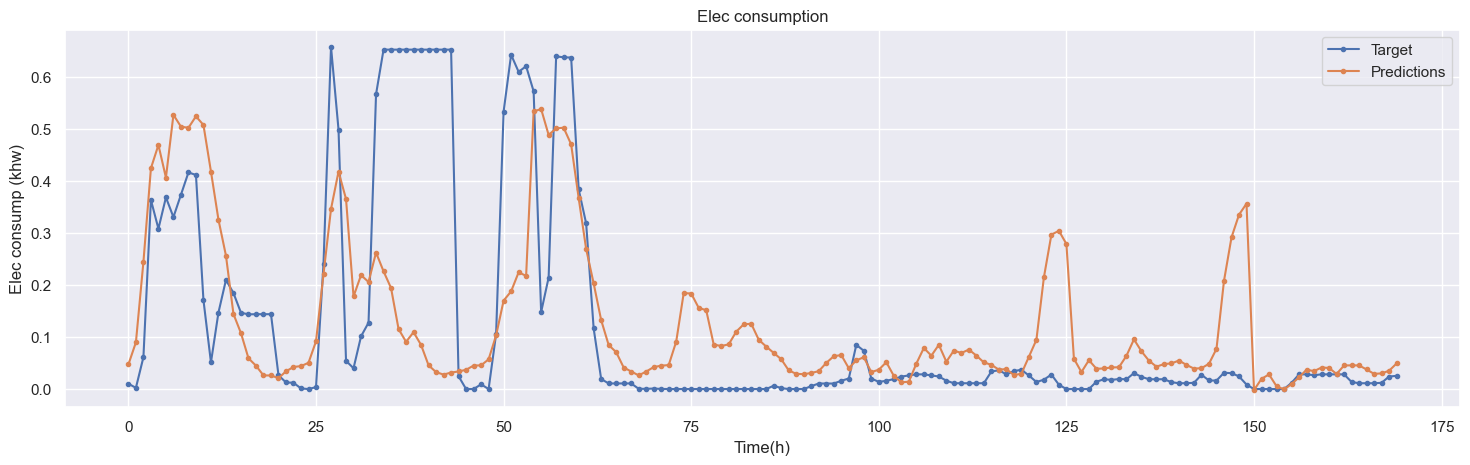

In [50]:
plt.figure(figsize=(18,5))

plt.plot(final_test[330:500], marker='.',label='Target')
plt.plot(final_resut[330:500], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [51]:
print( "The RMSE for Stacked LSTM model is: %f" %np.sqrt(mean_squared_error(final_test,final_resut)))
print( "The accuracy of Stacked LSTM model is: %f" %r2_score(final_test,final_resut))

The RMSE for Stacked LSTM model is: 0.152358
The accuracy of Stacked LSTM model is: 0.430627
